# Explainability pretrained CNN using VGG16

In [1]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
from keras.utils import image_dataset_from_directory

In [2]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16_copy.h5"

IMG_SIZE = 299

In [5]:
from tensorflow.keras.models import load_model

model = load_model(model_path)
model.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 299, 299, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 2,361,860
Non-tr

In [6]:
reference_model = tf.keras.applications.VGG16(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='max')


58889256/58889256 [==============================] - 1s 0us/step


This will be the input image we will use. The picture is not part of images that the network was trained on:

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [54]:
img_path = "/content/drive/Shareddrives/Progetto_CIDL/test_amanita.jpg"
# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Its shape is (1, 180, 180, 3)
print(img_tensor.shape)

(1, 299, 299, 3)


Here the picture is shown

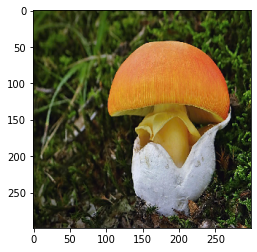

In [55]:
import matplotlib.pyplot as plt

#plt.imshow(img_tensor[0].astype('uint8'))
plt.imshow(img)
plt.show()

In order to extract the feature maps we want to look at, we will create a tf.keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. 

##Visualizing convnet filters

In this part we are going to display the visual pattern that each filter is meant to respond to, so which input image maximizes the response of a specific filter.

Retrieve the name of all the convolutional layers in the model

In [ ]:
for layer in reference_model.layers:
  if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


Create a new model that acts as a *specific* feature extractor.

In [ ]:
layer_name = "block1_conv2"
layer = reference_model.get_layer(name=layer_name)
feature_extractor = tf.keras.Model(inputs=reference_model.input, outputs=layer.output)

In [ ]:
activation = feature_extractor(
    preprocess_input(img_tensor)
)

Let’s use our feature extractor model to define a function that returns a scalar value quantifying how much a given input image "activates" a given filter in the layer. This is the "loss  function" (or *fitness*) that will be maximized.

In [ ]:
def compute_loss(image, layer_name, filter_index):
  ''' compute loss for gradient ascent
  
  image: input image tensor
  layer_name: name of the conv layer we are considering
  filter index: index of the filter we are considering (i.e., feature map of the output of a given conv layer) 
  '''
  layer = reference_model.get_layer(name=layer_name)
  feature_extractor = tf.keras.Model(inputs=reference_model.input, outputs=layer.output)
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index] # avoid border artifacts
  return tf.reduce_mean(filter_activation) # return mean activation values for the filter

Gradient ascent step function definition

In [ ]:
def gradient_ascent_step(image, layer_name, filter_index, learning_rate):
    with tf.GradientTape() as tape: # inside the scope, perform some tensor operations
        tape.watch(image) # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable (only Variables are automatically watched in a gradient tape).
        loss = compute_loss(image, layer_name, filter_index) # how much the current image activates the filter.
    # then, outside the scope, retrieve the gradients based on the "recorded" variables
    grads = tape.gradient(loss, image) # Compute the gradients of the loss with respect to the image.
    grads = tf.math.l2_normalize(grads) # gradient normalization trick
    image += learning_rate * grads # Move the image a little bit in a direction that activates our target filter more strongly.
    return image

In [ ]:
def generate_filter_pattern(layer_name, filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform( # initialize an image tensor with random values in the range centered in 0.5
        minval=0.4,
        maxval=0.6,
        shape=(1, IMG_SIZE, IMG_SIZE, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, layer_name, filter_index, learning_rate)
    return image[0].numpy()

Results visualization

In [ ]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :] #avoid border artifacts
    return image

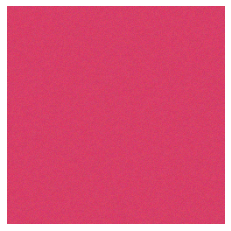

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(layer_name, filter_index=2)))

Now we can start visualizing the preferred pattern for every single filter in every layer

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(layer_name, filter_index)
    )
    all_images.append(image)

margin = 5
n_i = 8
n = 8
cropped_width = IMG_SIZE - 25 * 2
cropped_height = IMG_SIZE - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n_i):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

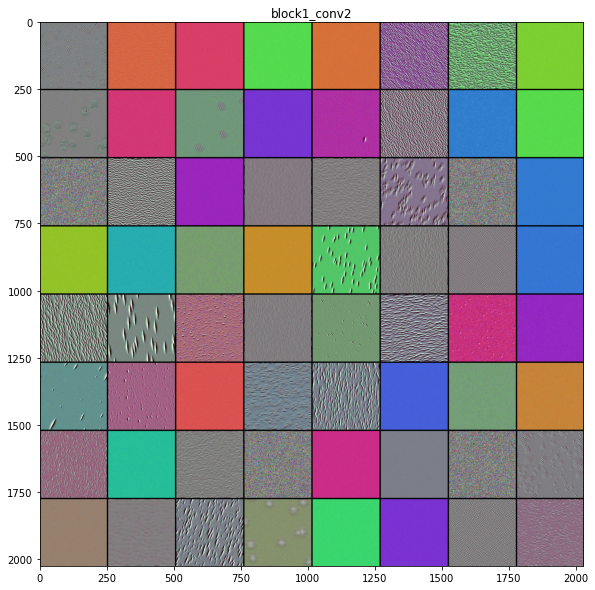

In [ ]:
plt.figure(figsize=(10, 10))
plt.title(layer_name)
plt.imshow(stitched_filters.astype("uint8"))
plt.show()

## Visualizing heatmaps of class activation

In this section we want to visualize heatmaps of class activation. In this way we create a 2D grid of scores associated with specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered.

In [56]:
def get_img_array(img_path, target_size):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(IMG_SIZE, IMG_SIZE))

Using the model to classify the input image

In [57]:
preds = model.predict(img_array)

1/1 [==============================] - 1s 1s/step


For the GradCAM process, we need a custom model that maps the input image to the activations of the last convolutional layer

In [58]:
model.layers[4]

In [59]:
last_conv_layer_name = "block5_conv3" # output shape (None, 18, 18, 512)
last_conv_layer = reference_model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(reference_model.inputs, last_conv_layer.output)

#last_conv_layer_model.summary()

Then we create a model that maps the activationbs of the last convolutional layer to the final class predictions

In [60]:
classifier_layer_names = [
    #"avg_pool",
    #"flatten",
    #"dropout_1",
    "dense_3",
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
#x = tf.keras.layers.Dropout(0.28)(x)
#x = tf.keras.layers.Dense(4)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 18, 18, 512)]     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 512)        0         
 2D)                                                             
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2,052
Trainable params: 2,052
Non-trainable params: 0
_________________________________________________________________


We compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer

In [61]:
#import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)  
    top_pred_index = tf.argmax(preds[0])  #  "Boletus" index
    top_class_channel = preds[:, top_pred_index] # "Boletus" prediction value
    print(top_pred_index)
    print(top_class_channel)

grads = tape.gradient(top_class_channel, last_conv_layer_output) # gradient of the "Boletus" class with regard to the output feature maps of our last conv layer

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([0.9606522], shape=(1,), dtype=float32)


In [62]:
grads.shape # same shape of conv2d_2 output

TensorShape([1, 18, 18, 512])

In [63]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 384 elements
print(pooled_grads.shape)
weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

(512,)


The channel-wise mean of the resulting feature map is our heatmap of class activation

In [64]:
heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)

Normalization trick for visualization

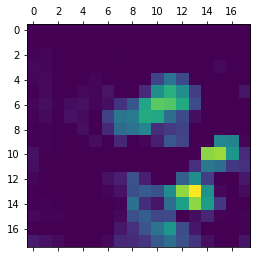

In [65]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Superimpose the heatmap to the original image

In [66]:
import matplotlib.cm as cm

img = tf.keras.utils.load_img(img_path)
img = tf.keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
print(jet)
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

save_path = "/content/drive/Shareddrives/Progetto_CIDL/amanita_VGG16.jpg"
superimposed_img.save(save_path)

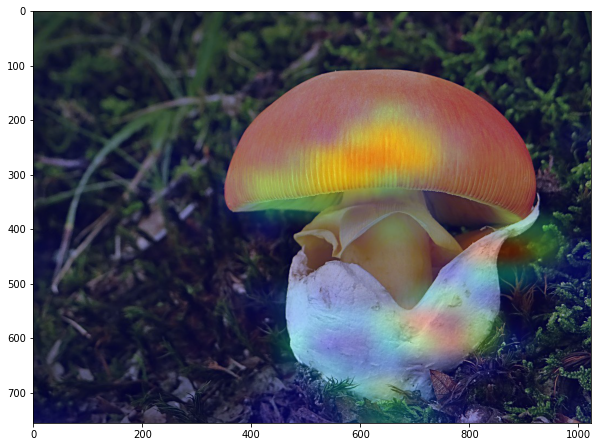

In [67]:
plt.figure(figsize= (10,10))
plt.imshow(superimposed_img)